In [3]:
from __future__ import print_function
#%matplotlib inline
import os
import glob
import csv
import random
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim

import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import HTML
import os

manualSeed = 999

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# tensorboard

%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Скачать датасет

In [ ]:
!gdown --id 1Of_EVz-yHV7QVWQGihYfvtny9Ne8qXVz -O CASIA-WebFace.zip
!unzip /content/CASIA-WebFace.zip
!rm /content/CASIA-WebFace.zip

Преобразовать датасет в вид csv таблицы

In [7]:
data = []

labels_paths = glob.glob('/content/CASIA-WebFace/' + '*')
n_labels = len(labels_paths)

for i in range(n_labels):
  for j in range(len(glob.glob(labels_paths[i] + '/*.jpg'))):
    data.append([glob.glob(labels_paths[i] + '/*.jpg')[j], labels_paths[i].split('/')[-1]])

with open('data.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['image', 'label'])
  writer.writerows(data)


Dataset

In [6]:
class CasiaDataset(Dataset):
  def __init__(self, 
               imgs_path,
               csv_file,
               transform
               ):
    self.imgs_path = imgs_path
    self.data = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    self.data = self.data.sample(frac=1)
  
    image = Image.open(self.data.iloc[index, 0])

    if self.transform:
      image = self.transform(image)

    return image

In [7]:
transform = transforms.Compose([
                                transforms.CenterCrop((128, 128)), 
                                
                                transforms.Grayscale(),
                                transforms.ToTensor()
                                ])

sample_dataset = CasiaDataset(imgs_path = '/content/CASIA-WebFace/',
                          csv_file = '/content/data.csv',
                          transform = transform)

sample_loader = DataLoader(sample_dataset, 
                    batch_size=64,
                    )

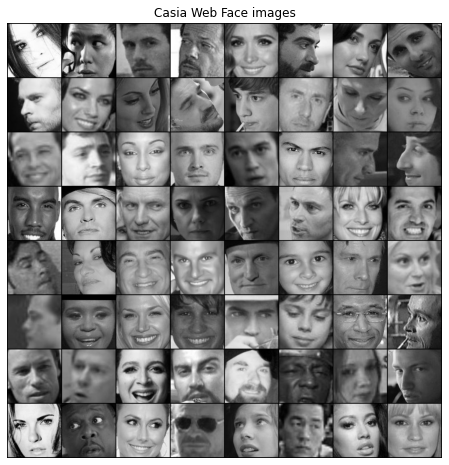

In [8]:
real_batch = next(iter(sample_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Casia Web Face images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('Casia_Web_Face.png')
plt.show()

In [9]:
num_epochs = 5
lr = 3e-4
ngpu = 1

batch_size = 64
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 1

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
# Generator Code for images with shape (128, 128)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
        

In [18]:
input = torch.randn(10,1,128,128)
model = Generator(ngpu = 1)
output = model(input)
output.shape

KeyboardInterrupt: ignored

In [12]:
# Discriminator for images with shape (128, 128)
ngpu = 1
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 3, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
)

In [14]:
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)
criterion = nn.BCELoss().to(device)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
n_noise = 100

In [15]:
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")

In [16]:
real_label = 1.
fake_label = 0.

training

In [21]:
# Training Loop

G_losses = []
D_losses = []
step = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(sample_loader, 0):

        netD.zero_grad()
        optimizerD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)

        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        optimizerG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(sample_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % 100 == 0:
            with torch.no_grad():
                fake = netG(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real_cpu, normalize = True)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize = True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1

Starting Training Loop...
[0/5][0/7726]	Loss_D: 22.6684	Loss_G: 4.1319	D(x): 0.9836	D(G(z)): 0.6034 / 0.2012


KeyboardInterrupt: ignored

In [ ]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: ignored